In [1]:
import os
import gc
os.chdir('../../')

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import arfs
import shap
sns.set(style='whitegrid')

### Read the parquet file located at `./week_1/data/processed/feature_engineering_dataset.parquet`

In [4]:
df = pd.read_parquet('./week_1/data/processed/feature_engineering_dataset.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5286530 entries, 0 to 3668009
Columns: 105 entries, Id to this_week_crypto_volume
dtypes: bool(1), datetime64[ns](1), datetime64[us](1), float64(73), int64(20), object(9)
memory usage: 4.1+ GB


### Preprocessing

In [5]:
cat_features = ['job', 'country']
for col in cat_features:
    df[col] = df[col].fillna('').astype('category')

### Train, Validation, Test Split

In [62]:
train_max_date = '2022-01-01'
validation_max_date = '2023-01-01'
test_start_date = '2024-01-01'
target = 'churn'
features = [
            #'interest_rate', 
            'country', 'atm_transfer_in', 'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out', 'crypto_in', 'crypto_out', 
            'bank_transfer_in_volume', 'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume', 'complaints', 'from_competitor', 'job', 
            'churn_due_to_fraud', 'model_predicted_fraud', 'appointment', 'email', 'phone', 'whatsapp', 'customer_age', 'prior_emails', 'prior_appointments', 
            'prior_phones', 'prior_whatsapps', 'prior_count', 'prior_bank_balance', 'prior_crypto_balance', 
            #'prior_mean_days_between', 
            #'prior_min_days_between', 
            #'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_crypto_in', 'prior_mean_crypto_out', 'prior_mean_bank_transfer_in_volume', 
            #'prior_mean_bank_transfer_out_volume', 'prior_mean_crypto_in_volume', 'prior_mean_crypto_out_volume', 'prior_10D_count', 'prior_10D_mean_days_between', 'prior_10D_max_days_between', 
            #'prior_10D_min_days_between', 'prior_10D_mean_bank_transfer_in', 'prior_10D_mean_bank_transfer_out', 'prior_10D_mean_crypto_in', 'prior_10D_mean_crypto_out', 
            #'prior_10D_mean_bank_transfer_in_volume', 'prior_10D_mean_bank_transfer_out_volume', 'prior_10D_mean_crypto_in_volume', 'prior_10D_mean_crypto_out_volume', 
            #'prior_90D_count', 'prior_90D_mean_days_between', 'prior_90D_max_days_between', 'prior_90D_min_days_between', 'prior_90D_mean_bank_transfer_in', 'prior_90D_mean_bank_transfer_out', 
            #'prior_90D_mean_crypto_in', 'prior_90D_mean_crypto_out', 'prior_90D_mean_bank_transfer_in_volume', 'prior_90D_mean_bank_transfer_out_volume', 'prior_90D_mean_crypto_in_volume', 'prior_90D_mean_crypto_out_volume', 
            #'prior_180D_count', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_180D_mean_bank_transfer_in', 
            #'prior_180D_mean_bank_transfer_out', 'prior_180D_mean_crypto_in', 'prior_180D_mean_crypto_out', 'prior_180D_mean_bank_transfer_in_volume', 'prior_180D_mean_bank_transfer_out_volume', 
            #'prior_180D_mean_crypto_in_volume', 'prior_180D_mean_crypto_out_volume', 
            #'prior_365D_count', 'prior_365D_mean_days_between', 'prior_365D_max_days_between', 'prior_365D_min_days_between', 
            #'prior_365D_mean_bank_transfer_in', 'prior_365D_mean_bank_transfer_out', 'prior_365D_mean_crypto_in', 'prior_365D_mean_crypto_out', 'prior_365D_mean_bank_transfer_in_volume', 
            #'prior_365D_mean_bank_transfer_out_volume', 'prior_365D_mean_crypto_in_volume', 'prior_365D_mean_crypto_out_volume', 'this_week_bank_volume', 'this_week_crypto_volume'
]

train_df = df[df['date'] < train_max_date]
validation_df = df[(df['date'] >= train_max_date) & (df['date'] < validation_max_date)]
test_df = df[df['date'] >= test_start_date]

X_train, y_train = train_df[features], train_df[target]
X_validation, y_validation = validation_df[features], validation_df[target]
X_test, y_test = test_df[features], test_df[target]

print('Train shape: ', X_train.shape, y_train.shape)
print('Test shape: ', X_test.shape, y_test.shape)

Train shape:  (3138366, 28) (3138366,)
Test shape:  (1360472, 28) (1360472,)


In [63]:
y_train.value_counts(normalize=True)

churn
0    0.906082
1    0.093918
Name: proportion, dtype: float64

In [46]:
y_test.value_counts(normalize=True)

churn
0    0.880308
1    0.119692
Name: proportion, dtype: float64

### Train a Vanilla Baseline CatBoost Model

In [64]:
model = CatBoostClassifier(cat_features=cat_features, verbose=True)
print('Traning the model...')
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), early_stopping_rounds=10)

print('Evaluating the model...')
y_pred = model.predict_proba(X_validation)[:, 1]
logloss = log_loss(y_validation, y_pred)
roc_auc = roc_auc_score(y_validation, y_pred)
avg_precision = average_precision_score(y_validation, y_pred)
brier = brier_score_loss(y_validation, y_pred)

print(f'Log Loss: {logloss}')
print(f'ROC AUC: {roc_auc}')
print(f'Average Precision: {avg_precision}')
print(f'Brier Score: {brier}')

Traning the model...
Learning rate set to 0.231523
0:	learn: 0.5111728	test: 0.5651963	best: 0.5651963 (0)	total: 633ms	remaining: 10m 31s
1:	learn: 0.4167735	test: 0.5062952	best: 0.5062952 (1)	total: 1.11s	remaining: 9m 14s
2:	learn: 0.3666961	test: 0.4837417	best: 0.4837417 (2)	total: 1.61s	remaining: 8m 55s
3:	learn: 0.3402114	test: 0.4771772	best: 0.4771772 (3)	total: 2.18s	remaining: 9m 3s
4:	learn: 0.3250566	test: 0.4775784	best: 0.4771772 (3)	total: 2.65s	remaining: 8m 47s
5:	learn: 0.3166456	test: 0.4804252	best: 0.4771772 (3)	total: 3.08s	remaining: 8m 30s
6:	learn: 0.3118202	test: 0.4844703	best: 0.4771772 (3)	total: 3.54s	remaining: 8m 22s
7:	learn: 0.3089688	test: 0.4881569	best: 0.4771772 (3)	total: 4.08s	remaining: 8m 25s
8:	learn: 0.3064909	test: 0.4922698	best: 0.4771772 (3)	total: 4.52s	remaining: 8m 17s
9:	learn: 0.3052412	test: 0.4949233	best: 0.4771772 (3)	total: 4.92s	remaining: 8m 6s
10:	learn: 0.3040230	test: 0.4977552	best: 0.4771772 (3)	total: 5.36s	remaining:

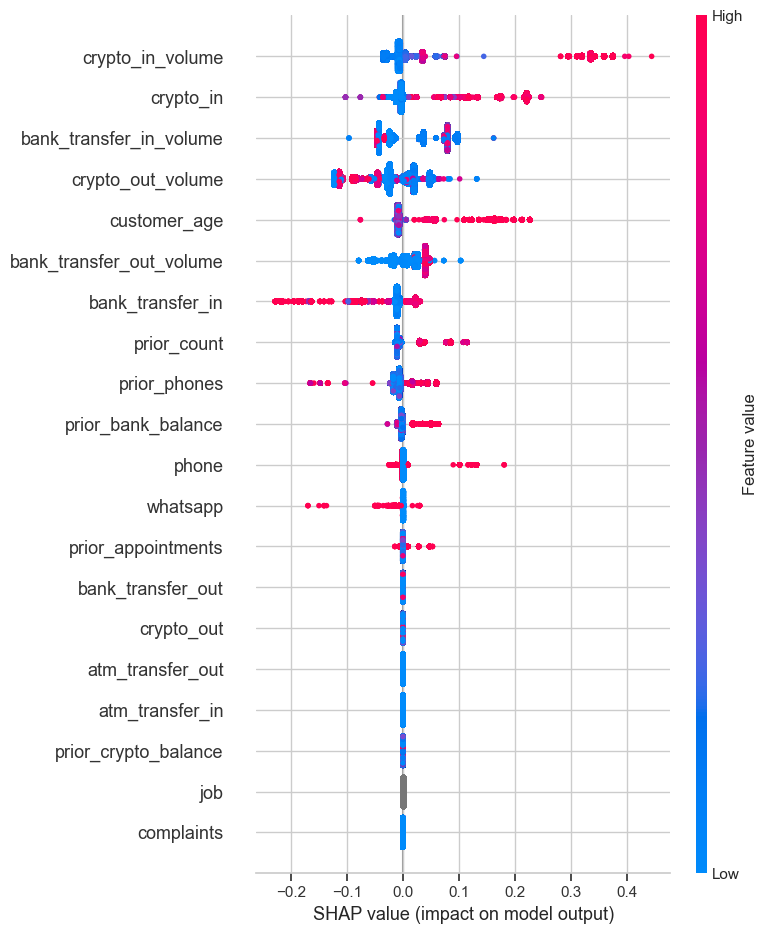

In [69]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_validation)
shap.summary_plot(shap_values, X_validation, plot_type="dot")

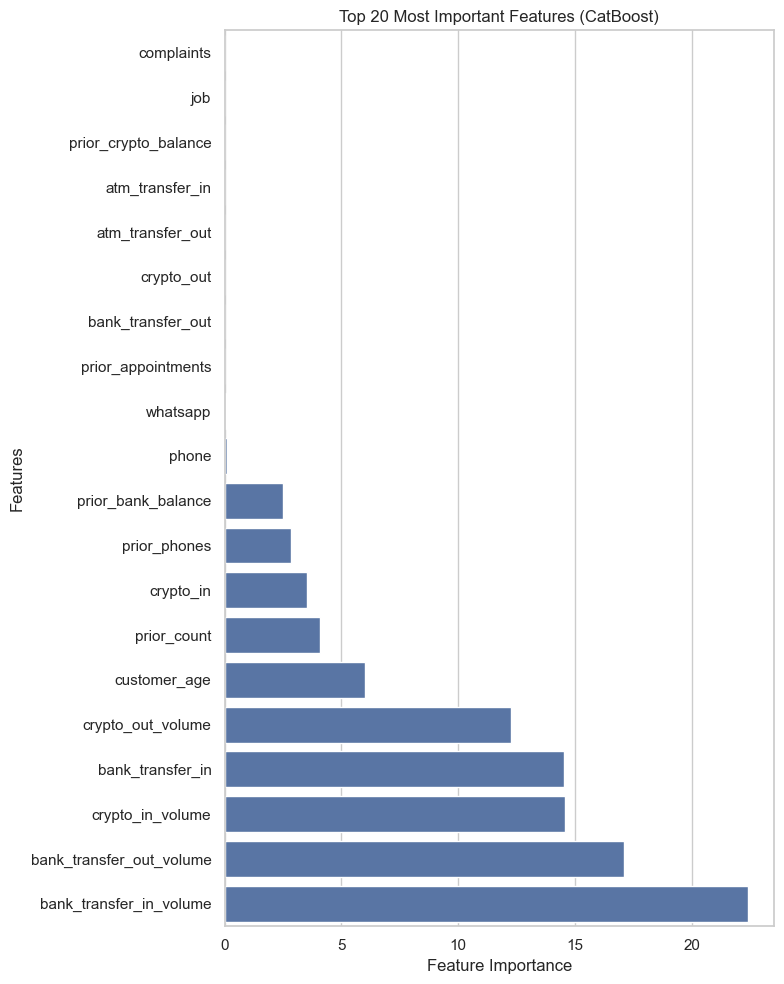

In [66]:
feature_importance = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.get_feature_importance()
})
feature_importance = feature_importance.sort_values('importance', ascending=True)

# Plot top 20 most important features 
plt.figure(figsize=(8, 10))
sns.barplot(data=feature_importance.tail(20), y='feature', x='importance', orient='h')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Most Important Features (CatBoost)')
plt.tight_layout()
plt.show()

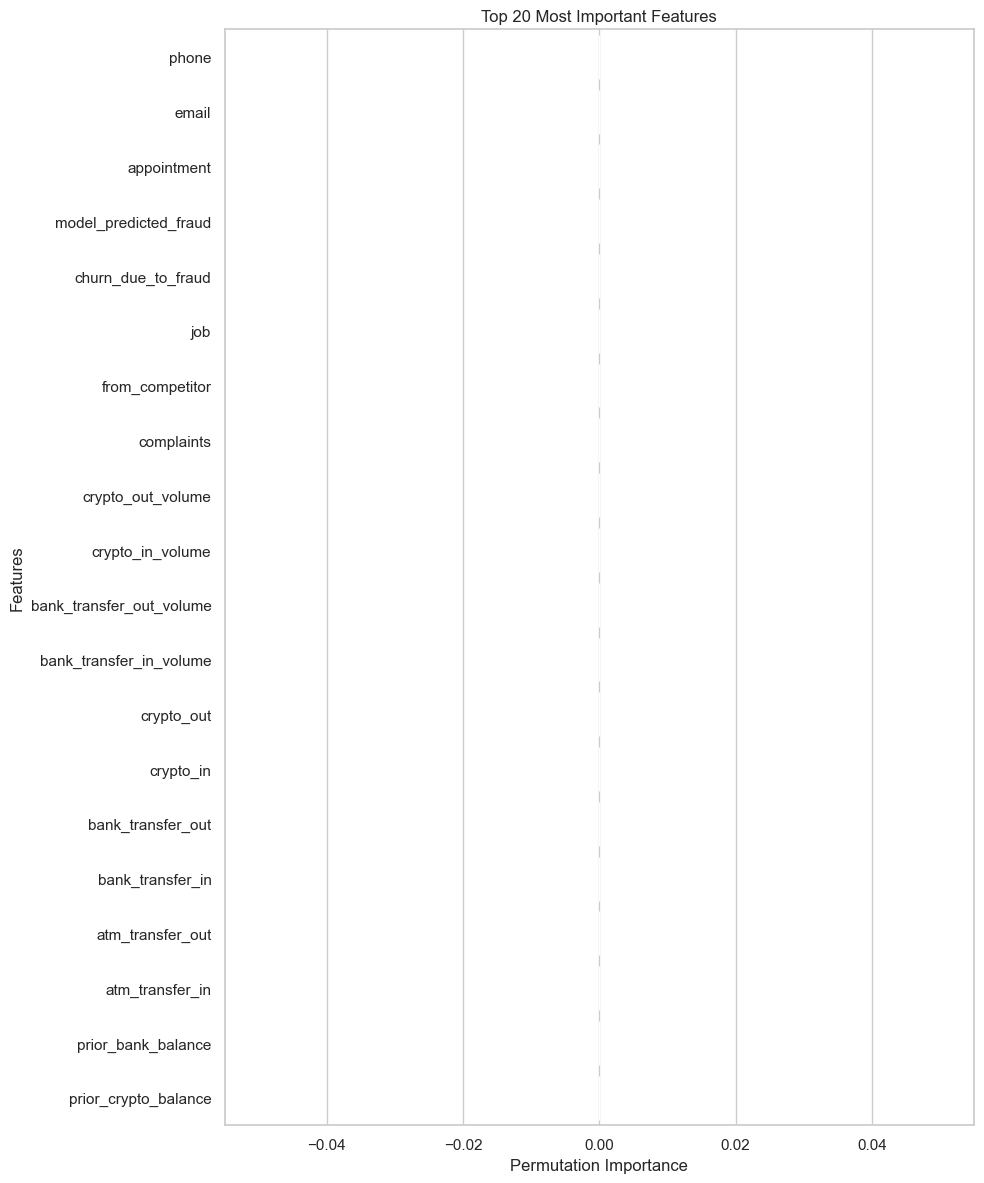

In [65]:
# Calculate permutation importance
result = permutation_importance(model, X_validation, y_validation, n_repeats=5, random_state=42)

# Sort features by importance
feature_importance = pd.DataFrame({'feature': features, 'importance': result.importances_mean})
feature_importance = feature_importance.sort_values('importance', ascending=True)

# Plot top 20 most important features using seaborn
plt.figure(figsize=(10, 12))
sns.barplot(data=feature_importance.tail(20), y='feature', x='importance', orient='h')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()


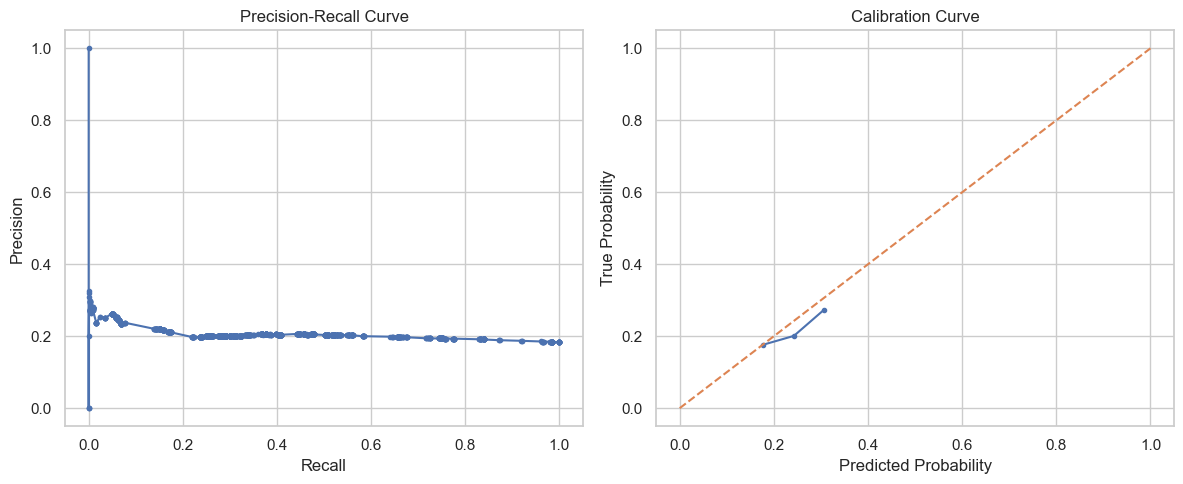

In [67]:
precision, recall, _ = precision_recall_curve(y_validation, y_pred)
prob_true, prob_pred = calibration_curve(y_validation, y_pred, n_bins=10)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.subplot(1, 2, 2)
plt.plot(prob_pred, prob_true, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')

plt.tight_layout()
plt.show()

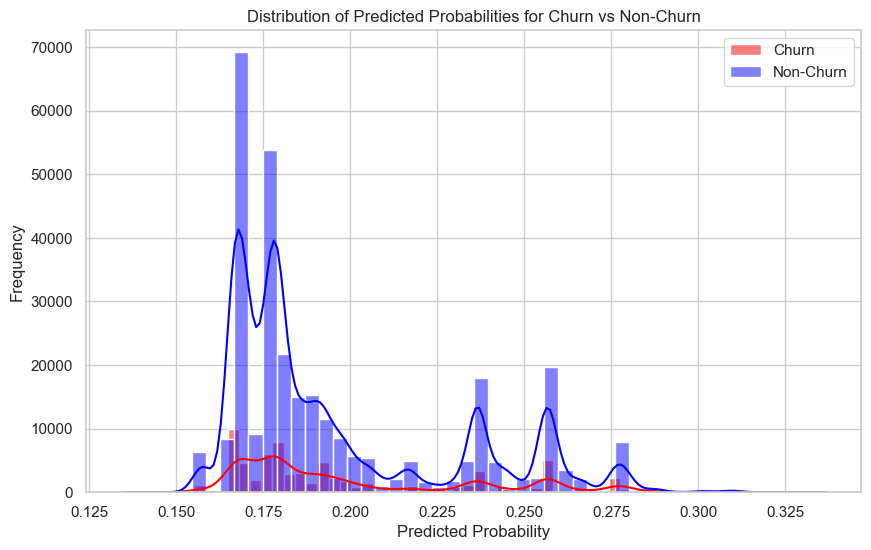

In [68]:
plt.figure(figsize=(10, 6))

sns.histplot(y_pred[y_validation == 1], bins=50, color='red', label='Churn', kde=True)
sns.histplot(y_pred[y_validation == 0], bins=50, color='blue', label='Non-Churn', kde=True)

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities for Churn vs Non-Churn')
plt.legend()
plt.show()

### Feature Selection with Boruta

In [ ]:
model = CatBoostClassifier(random_state=42, verbose=0)

feat_selector = arfs.arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=50, random_state=42, importance="permutation"
)          

feat_selector.fit(X=X_train, y=y_train)

selector = feat_selector
selected_features = feat_selector.get_feature_names_out()

feat_selector.plot_importance()

cat_features_selected = [feature for feature in selected_features if feature in cat_features]

### Train a Vanilla CatBoost Model with Selected Features

In [ ]:
model_selected = CatBoostClassifier(cat_features=cat_features_selected, verbose=0)
model_selected.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_selected = model_selected.predict_proba(X_validation[selected_features])[:, 1]
logloss_selected = log_loss(y_validation, y_pred_selected)
roc_auc_selected = roc_auc_score(y_validation, y_pred_selected)
avg_precision_selected = average_precision_score(y_validation, y_pred_selected)
brier_selected = brier_score_loss(y_validation, y_pred_selected)

print(f'Log Loss: {logloss_selected}')
print(f'ROC AUC: {roc_auc_selected}')
print(f'Average Precision: {avg_precision_selected}')
print(f'Brier Score: {brier_selected}')

In [ ]:
precision_selected, recall_selected, _ = precision_recall_curve(y_validation, y_pred_selected)
prob_true_selected, prob_pred_selected = calibration_curve(y_validation, y_pred_selected, n_bins=10)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall_selected, precision_selected, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Selected Features)')

plt.subplot(1, 2, 2)
plt.plot(prob_pred_selected, prob_true_selected, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve (Selected Features)')

plt.tight_layout()
plt.show()

### Perform Optuna Hyperparameter Tuning

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e-1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-4, 1e-1),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-4, 1e-1),
        'cat_features': cat_features_selected,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation), early_stopping_rounds=50)
    y_pred = model.predict_proba(X_validation[selected_features])[:, 1]
    return log_loss(y_validation, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f'Best parameters: {best_params}')

### Retrain the Model with the Best Parameters

In [ ]:
model_best = CatBoostClassifier(**best_params)
model_best.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_best = model_best.predict_proba(X_validation[selected_features])[:, 1]
logloss_best = log_loss(y_validation, y_pred_best)
roc_auc_best = roc_auc_score(y_validation, y_pred_best)
avg_precision_best = average_precision_score(y_validation, y_pred_best)
brier_best = brier_score_loss(y_validation, y_pred_best)

print(f'Log Loss: {logloss_best}')
print(f'ROC AUC: {roc_auc_best}')
print(f'Average Precision: {avg_precision_best}')
print(f'Brier Score: {brier_best}')

### Perform Model Calibration

In [ ]:
calibrated_model = CalibratedClassifierCV(model_best, method='sigmoid')
calibrated_model.fit(X_train[selected_features], y_train)

y_pred_calibrated = calibrated_model.predict_proba(X_validation[selected_features])[:, 1]
logloss_calibrated = log_loss(y_validation, y_pred_calibrated)
roc_auc_calibrated = roc_auc_score(y_validation, y_pred_calibrated)
avg_precision_calibrated = average_precision_score(y_validation, y_pred_calibrated)
brier_calibrated = brier_score_loss(y_validation, y_pred_calibrated)

print(f'Log Loss: {logloss_calibrated}')
print(f'ROC AUC: {roc_auc_calibrated}')
print(f'Average Precision: {avg_precision_calibrated}')
print(f'Brier Score: {brier_calibrated}')

In [ ]:
precision_calibrated, recall_calibrated, _ = precision_recall_curve(y_validation, y_pred_calibrated)
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_validation, y_pred_calibrated, n_bins=10)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall_calibrated, precision_calibrated, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Calibrated)')

plt.subplot(1, 2, 2)
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve (Calibrated)')

plt.tight_layout()
plt.show()